In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%qtconsole

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.INFO)

In [3]:
from loren_frank_data_processing import get_interpolated_position_dataframe, get_trial_time
from src.parameters import ANIMALS, SAMPLING_FREQUENCY

epoch_key = ('bon', 3, 2)

position_info = get_interpolated_position_dataframe(epoch_key, ANIMALS)

In [4]:
resample = '2ms'

linear_distance = (position_info.linear_distance
                   .resample(resample).mean().values)
is_nan_position = np.isnan(linear_distance)
linear_distance = linear_distance[~is_nan_position]
speed = position_info.linear_speed.resample(resample).mean()[~is_nan_position]
time = position_info.resample(resample).mean().index[~is_nan_position]

In [5]:
from loren_frank_data_processing import make_tetrode_dataframe, get_LFPs

tetrode_info = make_tetrode_dataframe(ANIMALS).xs(
    epoch_key, drop_level=False)
is_tetrode_number = (tetrode_info.index
                     .get_level_values('tetrode_number')
                     .isin([3, 5, 12, 14, 24, 29]))
tetrode_keys = tetrode_info[is_tetrode_number].index
lfps = get_LFPs(tetrode_keys, ANIMALS)

In [6]:
from spectral_connectivity import Multitaper, Connectivity

m = Multitaper(lfps.values, sampling_frequency=SAMPLING_FREQUENCY,
               time_halfbandwidth_product=1,
               time_window_duration=0.020,
               time_window_step=0.020,
               start_time=lfps.index[0].total_seconds())
c = Connectivity.from_multitaper(m)

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=1,
           time_window_duration=0.02, time_window_step=0.02,
           detrend_type='constant', start_time=3728.9837, n_tapers=1)


In [7]:
closest_200Hz_freq_ind = np.argmin(np.abs(c.frequencies - 200))
power = c.power()[..., closest_200Hz_freq_ind, :].squeeze()
power = pd.DataFrame(power, index=pd.TimedeltaIndex(c.time, unit='s'))
power = power.reindex(time)

In [8]:
from loren_frank_data_processing import make_neuron_dataframe, get_all_spike_indicators

neuron_info = make_neuron_dataframe(ANIMALS).xs(
    epoch_key, drop_level=False)
neuron_info = neuron_info.loc[(neuron_info.type == 'principal') & (neuron_info.numspikes > 0)]
spikes = get_all_spike_indicators(neuron_info.index, ANIMALS).resample('2ms').sum().reindex(time)

In [9]:
from loren_frank_data_processing import make_tetrode_dataframe
from ripple_detection import Karlsson_ripple_detector

def detect_epoch_ripples(epoch_key, animals, sampling_frequency,
                         position_info=None,
                         minimum_duration=np.timedelta64(15, 'ms'),
                         zscore_threshold=2,
                         close_ripple_threshold=np.timedelta64(0, 'ms')):
    '''Returns a list of tuples containing the start and end times of
    ripples. Candidate ripples are computed via the ripple detection
    function and then filtered to exclude ripples where the animal was
    still moving.
    '''

    tetrode_info = make_tetrode_dataframe(animals).xs(
        epoch_key, drop_level=False)

    tetrode_keys = tetrode_info.loc[tetrode_info.validripple > 0].index
    lfps = get_LFPs(tetrode_keys, animals)
    time = lfps.index
    if position_info is None:
        position_info = get_interpolated_position_dataframe(
            epoch_key, animals)
    speed = position_info.linear_speed

    return Karlsson_ripple_detector(
        time, lfps.values, speed.values, sampling_frequency,
        minimum_duration=minimum_duration, zscore_threshold=zscore_threshold,
        close_ripple_threshold=close_ripple_threshold)

In [10]:
from src.analysis import get_ripple_indicator
from replay_identification import ReplayDetector

ripple_times = detect_epoch_ripples(epoch_key, ANIMALS, SAMPLING_FREQUENCY,
                                    position_info=position_info)
is_ripple = get_ripple_indicator(
    epoch_key, ANIMALS, ripple_times, speed)

In [11]:
detector = ReplayDetector(replay_speed=10)
detector.fit(
    is_ripple, speed.values, linear_distance, power.values, spikes.values, multiunit=None)
results = detector.predict(
    speed, linear_distance, power.values, spikes.values, multiunit=None, time=time,
    use_likelihoods=['spikes', 'lfp_power'])

INFO:replay_identification.decoders:Fitting speed model...
INFO:replay_identification.decoders:Fitting LFP power model...
INFO:replay_identification.decoders:Fitting spiking model...


INFO:replay_identification.decoders:Fitting movement state transition...
INFO:replay_identification.decoders:Fitting replay state transition...


INFO:replay_identification.decoders:Predicting lfp_power likelihood...
INFO:replay_identification.decoders:Predicting spikes likelihood...


INFO:replay_identification.decoders:Predicting replay probability and density...


In [12]:
results

<xarray.Dataset>
Dimensions:             (position: 187, time: 465497)
Coordinates:
  * time                (time) timedelta64[ns] 01:02:09.025700 ... 01:17:40.017700
  * position            (position) float64 0.4979 1.494 2.489 ... 184.7 185.7
Data variables:
    replay_probability  (time) float64 0.0 1.69e-05 ... 0.0003027 0.0003083
    replay_posterior    (time, position) float64 0.0 0.0 ... 0.0005751 0.0005767
    prior               (time, position) float64 0.0 0.0 ... 0.0005586 0.0005599
    likelihood          (time, position) float64 1.042 1.044 ... 1.026 1.027

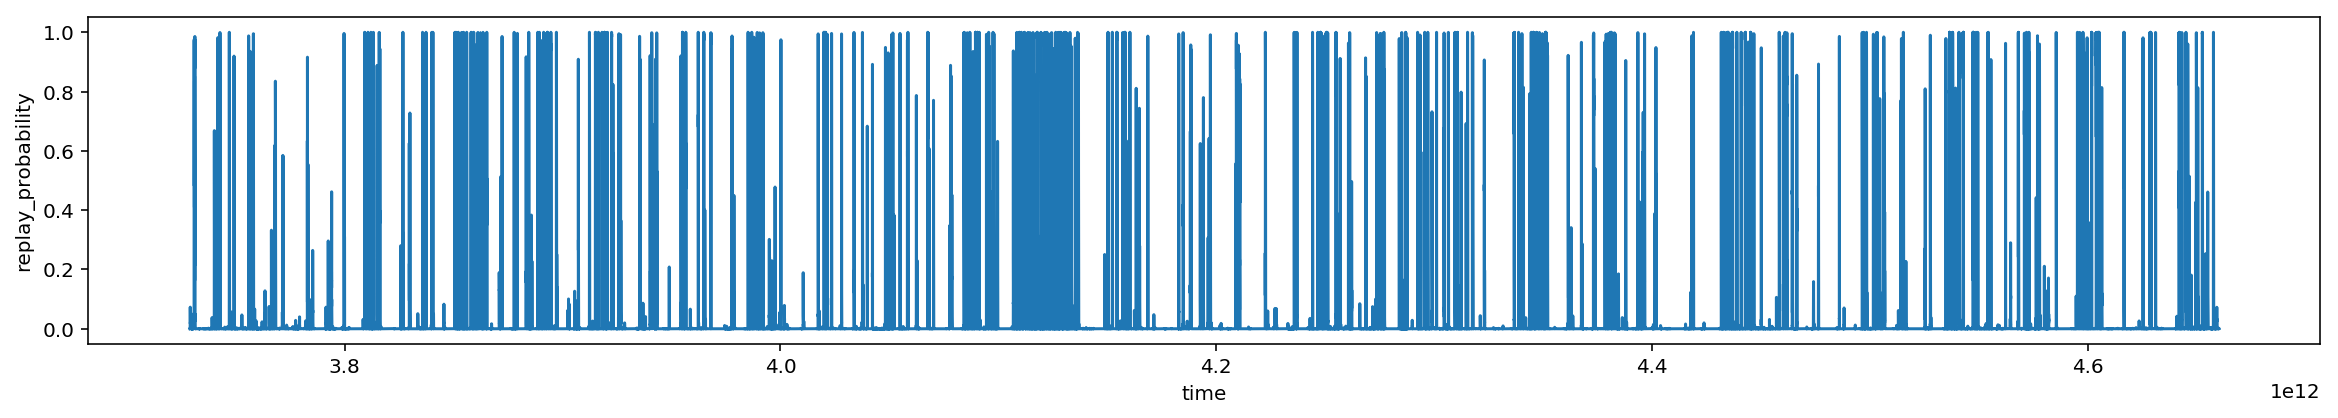

In [13]:
plt.figure(figsize=(20, 3))
results.replay_probability.plot();

### Figure 4

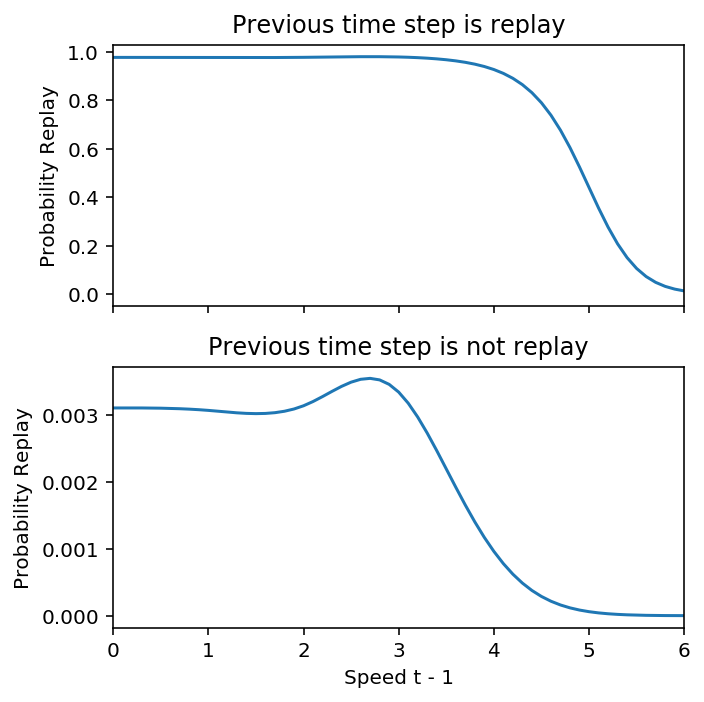

In [14]:
detector.plot_replay_state_transition()
plt.xlim((0, 6));

### Figure 5

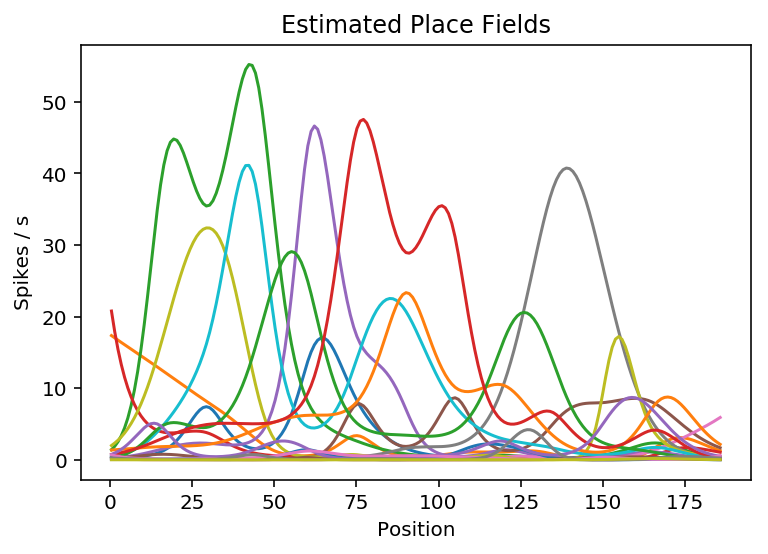

In [15]:
detector.plot_fitted_place_fields(sampling_frequency=SAMPLING_FREQUENCY)

### Figure 6

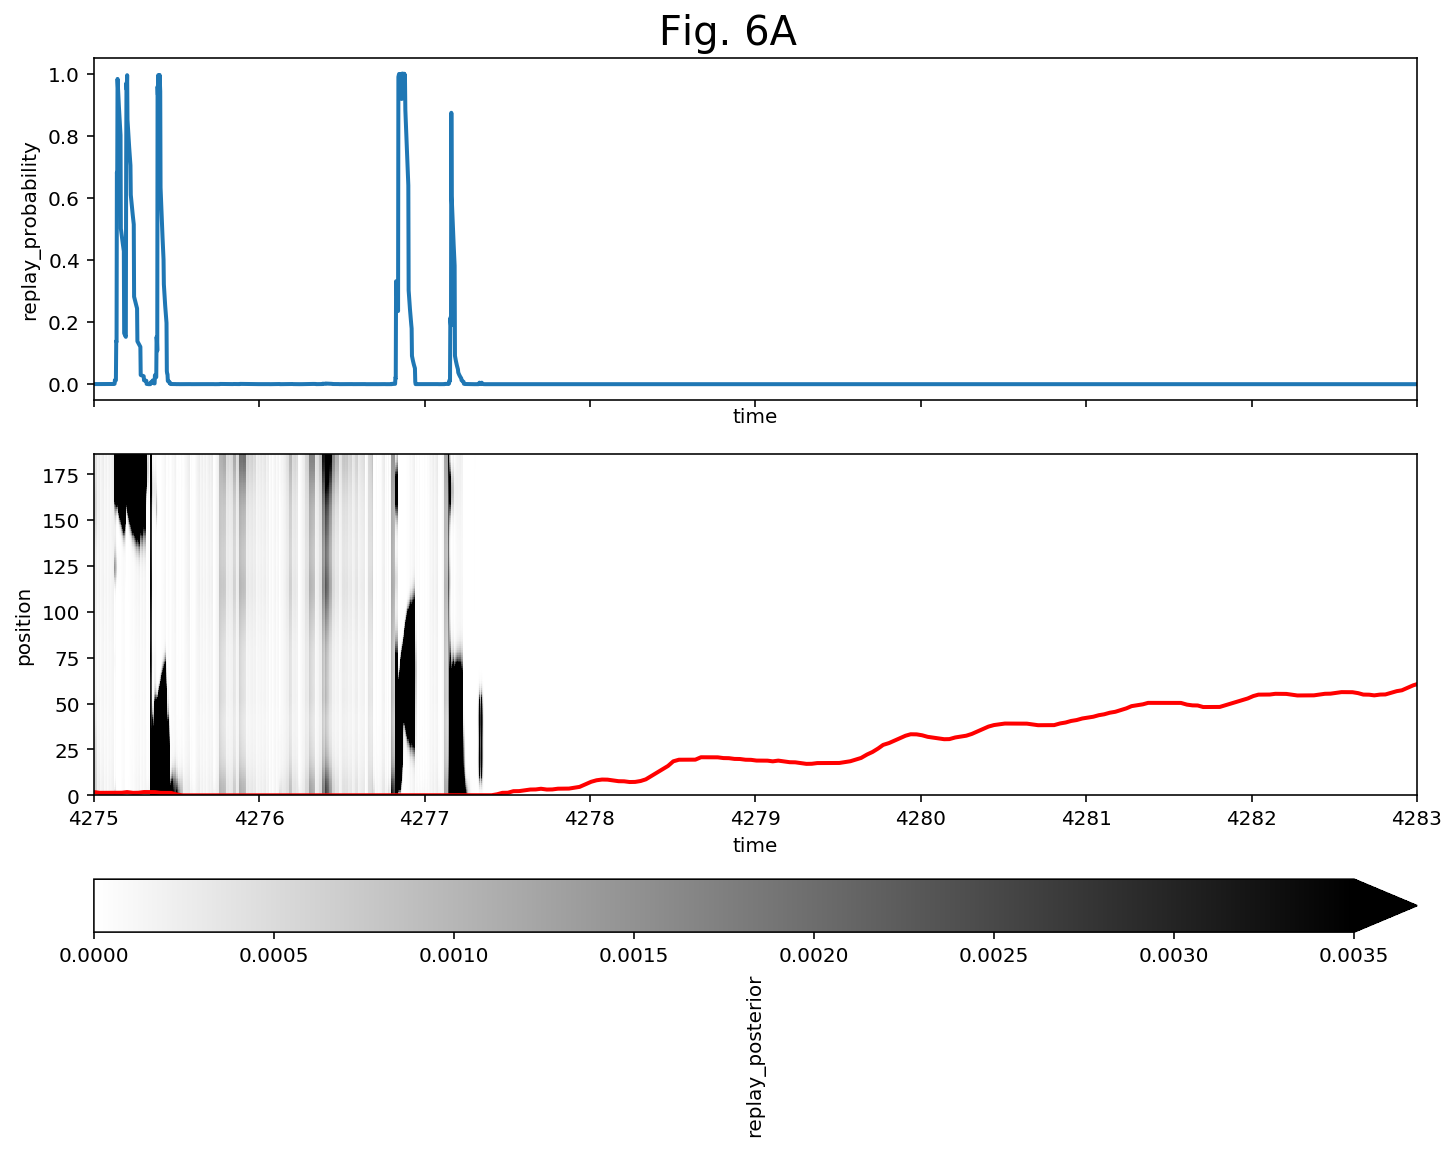

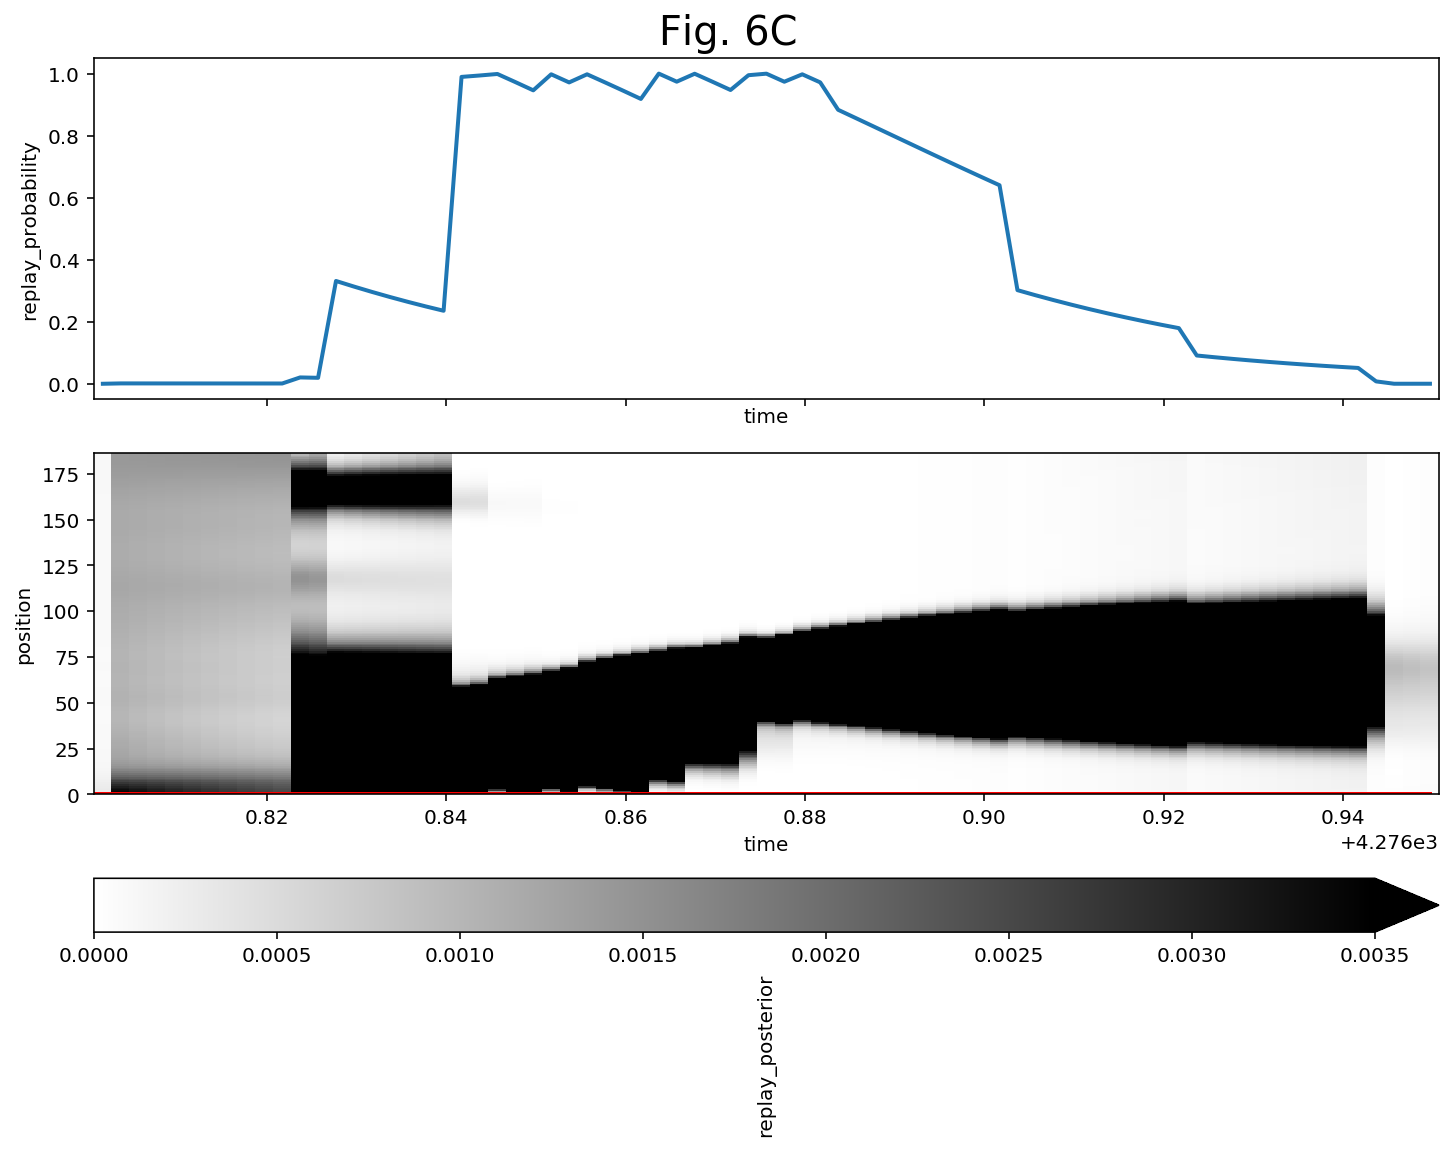

In [16]:
long_names = ['Fig. 6A', 'Fig. 6C']
long_times = [slice(4275, 4283), slice(4276.8, 4276.95)]

for t, fig_name in zip(long_times, long_names):
    fig, axes = plt.subplots(2, 1, figsize=(10, 8),
                             sharex=True, constrained_layout=True)    
    r = (results
         .assign_coords(time=results.time / np.timedelta64(1, 's'))
         .sel(time=t))
    r.replay_probability.plot(ax=axes[0], linewidth=2)
    
    
    g = r.replay_posterior.plot(
        x='time', y='position', cbar_kwargs=dict(orientation='horizontal'),
        ax=axes[1], cmap='gray_r', vmin=0.0, vmax=3.5E-3)
    
    p = position_info.set_index(position_info.index.total_seconds()).loc[t]
    axes[1].plot(p.index.values, p.linear_distance.values,
                 color='red', linewidth=2)

    fig.suptitle(fig_name, fontsize=20)